<font size=6>**看图作诗**</font>

In [76]:
# 可能需要预先安装的包
# !pip install zhon
# !pip install jieba

# 加载所有可能用到的包
import os
from os import listdir, mkdir
import string
import random

import numpy as np
from numpy import array, argmax
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pickle import dump, load
import zhon.hanzi
import jieba
import jieba.posseg

from keras import Model, regularizers
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, TimeDistributed, Lambda, BatchNormalization, Activation
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 背景引入

<font size=4>时常能拍到一张张好看的图片，却不知如何加一个高端的配文，只能说一两句干瘪的描述?</font>

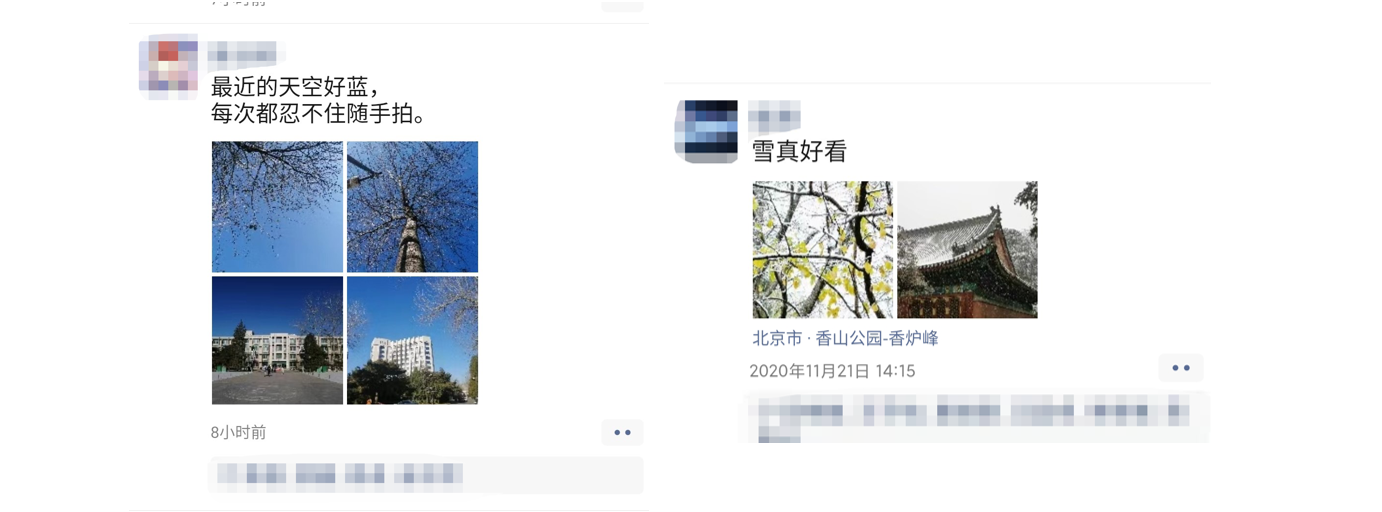

<font size=4>某天拍到一张美照，怎么配文案？</font>

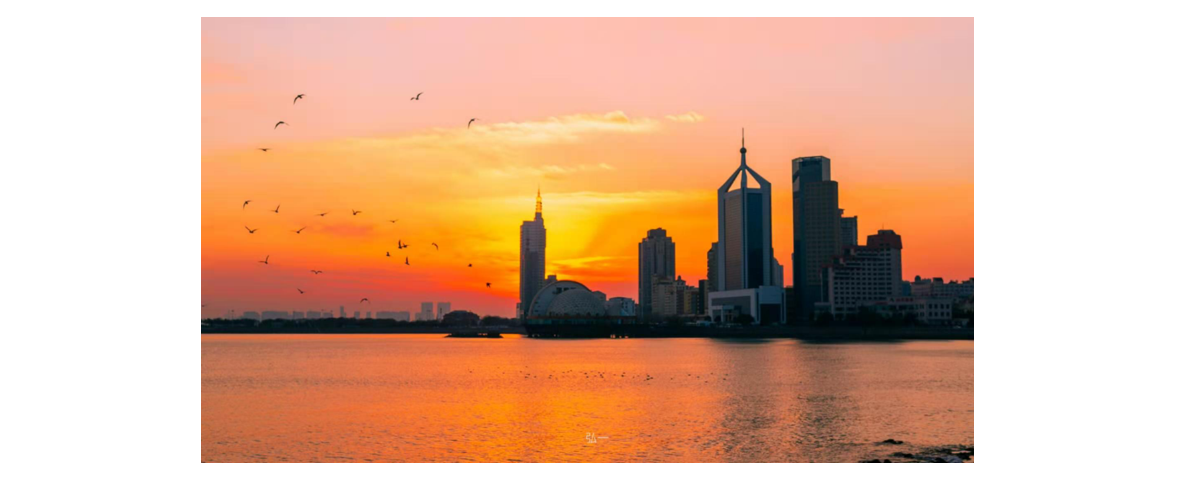

<font size=4>配一段诗如何？</font>

<font size=4 color=#FF571C>**落霞与孤鹜齐飞，秋水共长天一色。**</font>

<font size=4>没那水平写诗，又想有高水平文案，怎么办？</font>

<font size=4>让李白帮我们写一首怎么样？需要哪几步？</font>
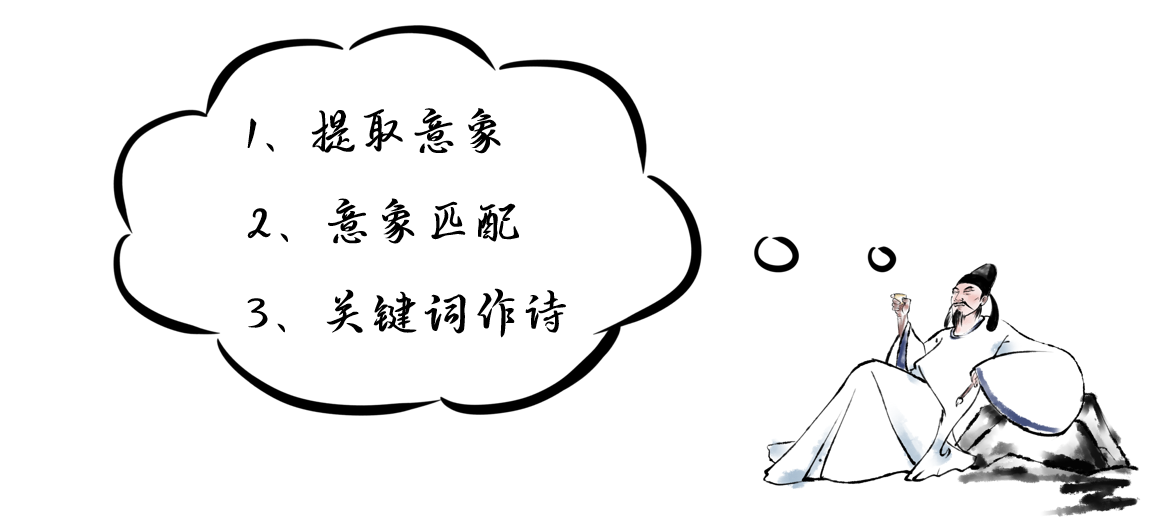

# 模型概述
1、提取意象：对应看图写话模型。输入一张图片，根据图片信息输出对图片的描述

2、意象匹配：对应关键词嵌入算法。输入前面得到的描述文本，提取其中在古诗词中常出现的字词，输出一个不完整诗句

3、关键词作诗：对应作诗模型。输入不完整诗句，根据古人作诗风格，补全不完整诗句，输出最终的完整诗句



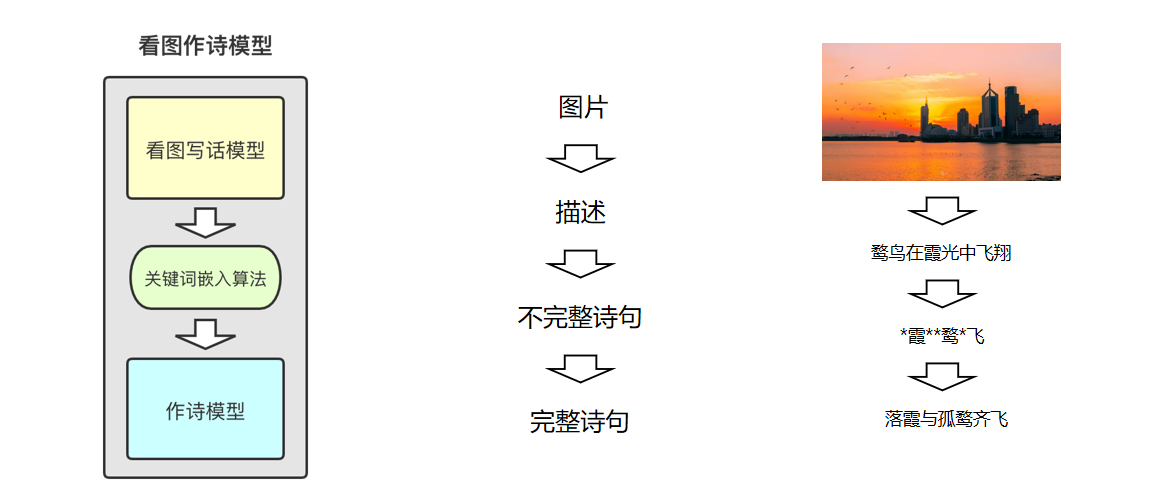

# 一、看图写话模型

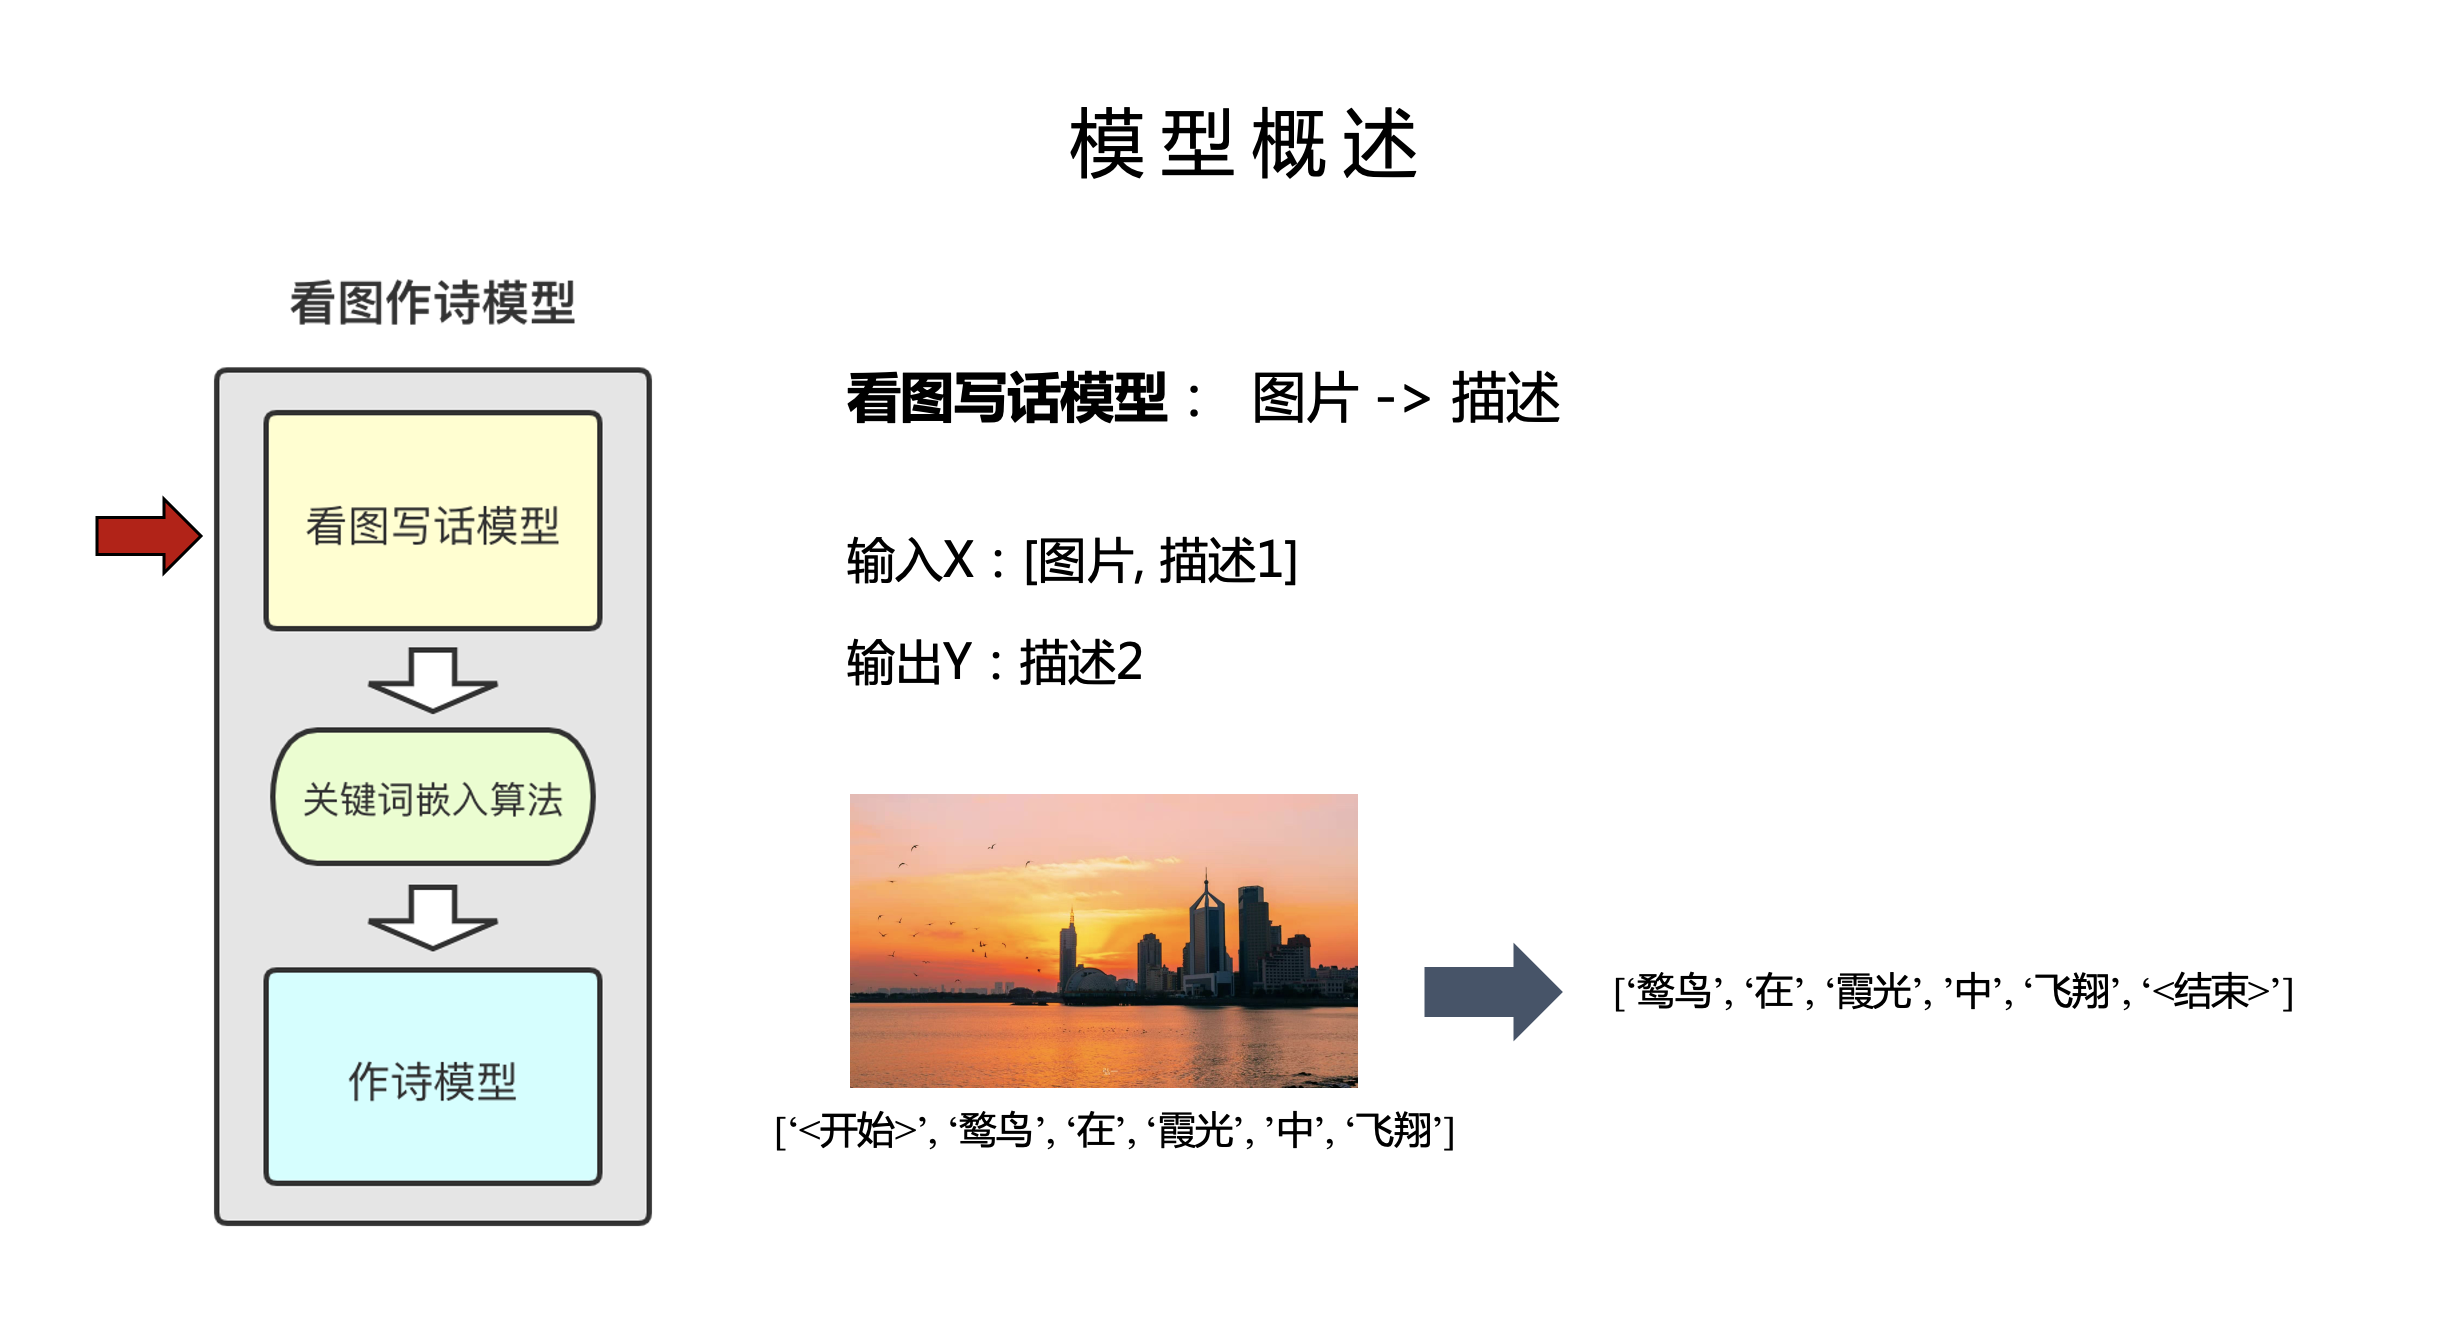

* 模型架构
    * 输入X：[图片，描述1]  
        * 图片是预训练inception提取好的2048 * 1 * 1的向量
          
        * 文字描述输入是最大长度为maxlen的序列(maxlen可根据七言或五言诗句调整)
        
    * 输出Y：[描述2]
        * 文字描述输入是最大长度为maxlen的序列
    * 整体模型： 将图片提取出2048 * 1 * 1的向量作为input，输入到encoderLSTM中，encoder输出的隐藏状态作为decoder的初始隐藏状态

## 数据预处理工作

<font size=4>**迁移学习的技巧：我们直接使用keras内置预训练的InceptionV3提取图片特征**</font>

In [77]:
#使用预训练好的inceptionV3
#这里也可以换用VGG等，但是注意调整特征维度和后续模型输入维度一致
def extract_features(directory):
    # 直接调用keras内置的inceptionV3(建议直接导入现成的权重文件，避免长时间下载)
    in_layer = Input(shape=(224, 224, 3))
    base_model = InceptionV3(weights='imagenet', input_tensor=in_layer) 
    # 去除最后的softmax层(即提取avg_pool层的输出)，因为目的不是分类，而是特征抽取
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
    model.summary()
    
    # 对每张图片抽取特征
    features = dict()
    for name in listdir(directory):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # 将像素转存为数组形式
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # 预处理并预测（实质返回的是对应图片的特征向量）
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        #以字典形式存储图片特征
        image_id = name.split('.')[0]
        features[image_id] = feature
        # print('>%s' % name)
    return features

In [78]:
#如果尚未创建路径，则创建路径
if not os.path.exists('MiddleFiles'):
    mkdir('MiddleFiles')
#如果尚未有提取好的特征则需要提取一下特征
if not os.path.exists('MiddleFiles/features.pkl'):
    features = extract_features('Data/Images')
    print('Extracted Features: %d' % len(features))
    dump(features, open('MiddleFiles/features.pkl', 'wb'))

<font size=4>**处理描述文本**</font>

In [79]:
#读入所有的文本文件信息
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# 用字典存储标题-语句信息
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        if not line:
            continue
        # 以空格为分隔把标题和描述语句分开
        tokens = line.split()
        # 第一个是图片标题，后面的是描述语句
        image_id, image_desc = tokens[0], tokens[1]
        if image_id[-1] != '0':
            continue
        # 去除.jpg的后缀
        image_id = image_id.split('.')[0]
        #以字典形式存储
        mapping[image_id] = image_desc
    return mapping

#保存处理好的文本文件
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc in descriptions.items():
        lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [80]:
# 保存文件
if not os.path.exists('MiddleFiles'):
    mkdir('MiddleFiles')
if not os.path.exists('MiddleFiles/descriptions.txt'):
    doc = load_doc('Data/Captions/flickr8kzhc.caption.txt')

    # 加载描述语句
    descriptions = load_descriptions(doc)
    print('Loaded: %d' % len(descriptions))
    
    save_descriptions(descriptions, 'MiddleFiles/descriptions.txt')

<font size=4>**载入提取好的图片特征和预处理的文本序列，划分训练集、测试集**</font>

In [81]:
# 获取训练集的图片名称
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        # 可能有空行
        if not line:
            continue
        dataset.append(line)
    return set(dataset)

# 根据图片名称加载描述语句
def load_clean_descriptions(filename, dataset):
    #zhon package里的标点符号表
    punctuations = string.punctuation + zhon.hanzi.punctuation
    #需要提出的停用词的词性（如x代表特殊符号
    poslist = ['dg','d','e','o','u','x','w','y','un']
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        if not line:
            continue
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1]
        image_descl = jieba.posseg.cut(image_desc)
        image_desc = []
        for word, pos in image_descl:
            #只保留词性为非停用词的部分文本
            if pos not in poslist:
                image_desc.append(word)
        
        # 描述语句首尾加开始/终止词，用于序列输入
        image_desc.insert(0, 'startseq')
        image_desc.append('endseq')
        
        # 跳过不在训练集中的图片
        if image_id in dataset:
            descriptions[image_id] = image_desc
    return descriptions

# 根据图片名称加载图片的特征向量
def load_photo_features(filename, dataset):
    features = load(open(filename, 'rb'))
    return features

In [82]:
#加载图片名称
image_ids_train = load_set('Data/Partition/flickr8ktrain.txt')
image_ids_val = load_set('Data/Partition/flickr8kval.txt')
#将训练集和测试集合并为总集合
image_ids = set.union(image_ids_train, image_ids_val)

print('Dataset: %d' % len(image_ids))

#通过图片名称得到图片的描述语句
descriptions_train = load_clean_descriptions('MiddleFiles/descriptions.txt', image_ids_train)
print('Descriptions_train: %d' % len(descriptions_train))

descriptions_val = load_clean_descriptions('MiddleFiles/descriptions.txt', image_ids_val)
print('Descriptions_val: %d' % len(descriptions_val))

descriptions = load_clean_descriptions('MiddleFiles/descriptions.txt', image_ids)
print('Descriptions: %d' % len(descriptions))


#通过图片名称得到图片的特征向量
features_train = load_photo_features('MiddleFiles/features.pkl', image_ids_train)
print('Photos_train: %d' % len(features_train))

#通过图片名称得到图片的特征向量
features_val = load_photo_features('MiddleFiles/features.pkl', image_ids_val)
print('Photos_val: %d' % len(features_val))

features = load_photo_features('MiddleFiles/features.pkl', image_ids)
print('Photos: %d' % len(features))

Dataset: 7000
Descriptions_train: 6000
Descriptions_val: 1000
Descriptions: 7000
Photos_train: 8091
Photos_val: 8091
Photos: 8091


<font size=4>**使用tokenizer将描述文本数字向量化**</font>

In [83]:
# 建立分词器tokenizer将词语对应为一个唯一的数字标识
def create_tokenizer(descriptions):
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# 将上面生成的tokenizer也存起来
if not os.path.exists('MiddleFiles'):
    mkdir('MiddleFiles')
if not os.path.exists('MiddleFiles/tokenizer.pkl'):
    tokenizer = create_tokenizer(descriptions)
    dump(tokenizer, open('MiddleFiles/tokenizer.pkl', 'wb'))
else:
    tokenizer = load(open('MiddleFiles/tokenizer.pkl', 'rb'))

# 输出所有语句不同的单词总数
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# 输出单个语句最大长度
max_length = max([len(desc) for desc in descriptions.values()])
print('Description Length: %d' % max_length)

Vocabulary Size: 2166
Description Length: 20


<font size=4>**由于我们数据形式的特殊性（即每个输入由一个图片特征和对应的描述文本数字向量组成），所以这里我们手动定义一下数据生成器**</font>

In [84]:
#因为数据存储格式的特殊性，下面我们需要手动写一些处理函数
#将文本描述数据集中每一句描述转换为onehot编码
def one_hot_encode(data, MAXIMUM_CAPTION_LENGTH, n_classes):
    result = np.zeros((len(data), MAXIMUM_CAPTION_LENGTH, n_classes))
    for i, item in enumerate(data):
        a = 0
        for j, word in enumerate(item):
            result[i, j, word] = 1.0
            a = j
        for k in range(a+1, MAXIMUM_CAPTION_LENGTH):
            result[i, k, 0] = 1.0
    return result

#手动完成数据生成器(主要是由于数据是以特殊的文本向量和图片对应的形式存储的)
def data_generator(batch_size, captions, get_image, tokenizer, max_length, vocab_size):
    #这里其实也就是和包里的data_generator差不多
    while True:
        for i in range(0,len(captions),batch_size):
            #将所有数据分为batch_size份
            #每次取出每个batch的indices
            if((i+batch_size)<(len(captions))):
                batch_indices = np.arange(i, i + batch_size)
            else :
                batch_indices = np.arange(i, len(captions))
        
            L = list(captions.keys())#每条文本描述的文件名列表

            batch_image_features = np.empty((len(batch_indices), 2048))
            for i, j in enumerate(batch_indices):
                #依次取出每个文件名已经提取好的图片特征
                batch_image_features[i] = get_image[L[j]]
            
            #这里的两个caption分别是训练时的输入和标签
            #和作诗的案例里的数据处理对照着就比较好理解了
            #输入和标签分别要做去尾和掐头的操作
            batch_captions1 = [captions[L[item]][:-1] for item in batch_indices]
            batch_captions2 = [captions[L[item]][1:] for item in batch_indices]

            #将描述转为数字向量
            input_captions = tokenizer.texts_to_sequences(batch_captions1)
            output_captions = tokenizer.texts_to_sequences(batch_captions2)

            #补零操作使其统一为长度max_length的向量
            input_captions = pad_sequences(input_captions, maxlen= max_length, padding='post')
            output_captions = one_hot_encode(output_captions, max_length, vocab_size)
            #将图片特征转为np.array
            batch_image_features = np.array(batch_image_features, dtype=np.float32)
            #把每个batch的输入(图片特征和文本向量)用一个外层list嵌套起来
            x_data = [batch_image_features,input_captions, 
                      np.zeros([input_captions.shape[0], unit_size]), np.zeros([input_captions.shape[0], unit_size])]
            #y就是训练用的标签Y
            y_data = output_captions
            #这里的yield与前面的while搭配使整个函数作为一个生成器(generater)
            #从而可以迭代输出每个batch的x_data和y_data
            yield (x_data, y_data)

## 模型定义与训练

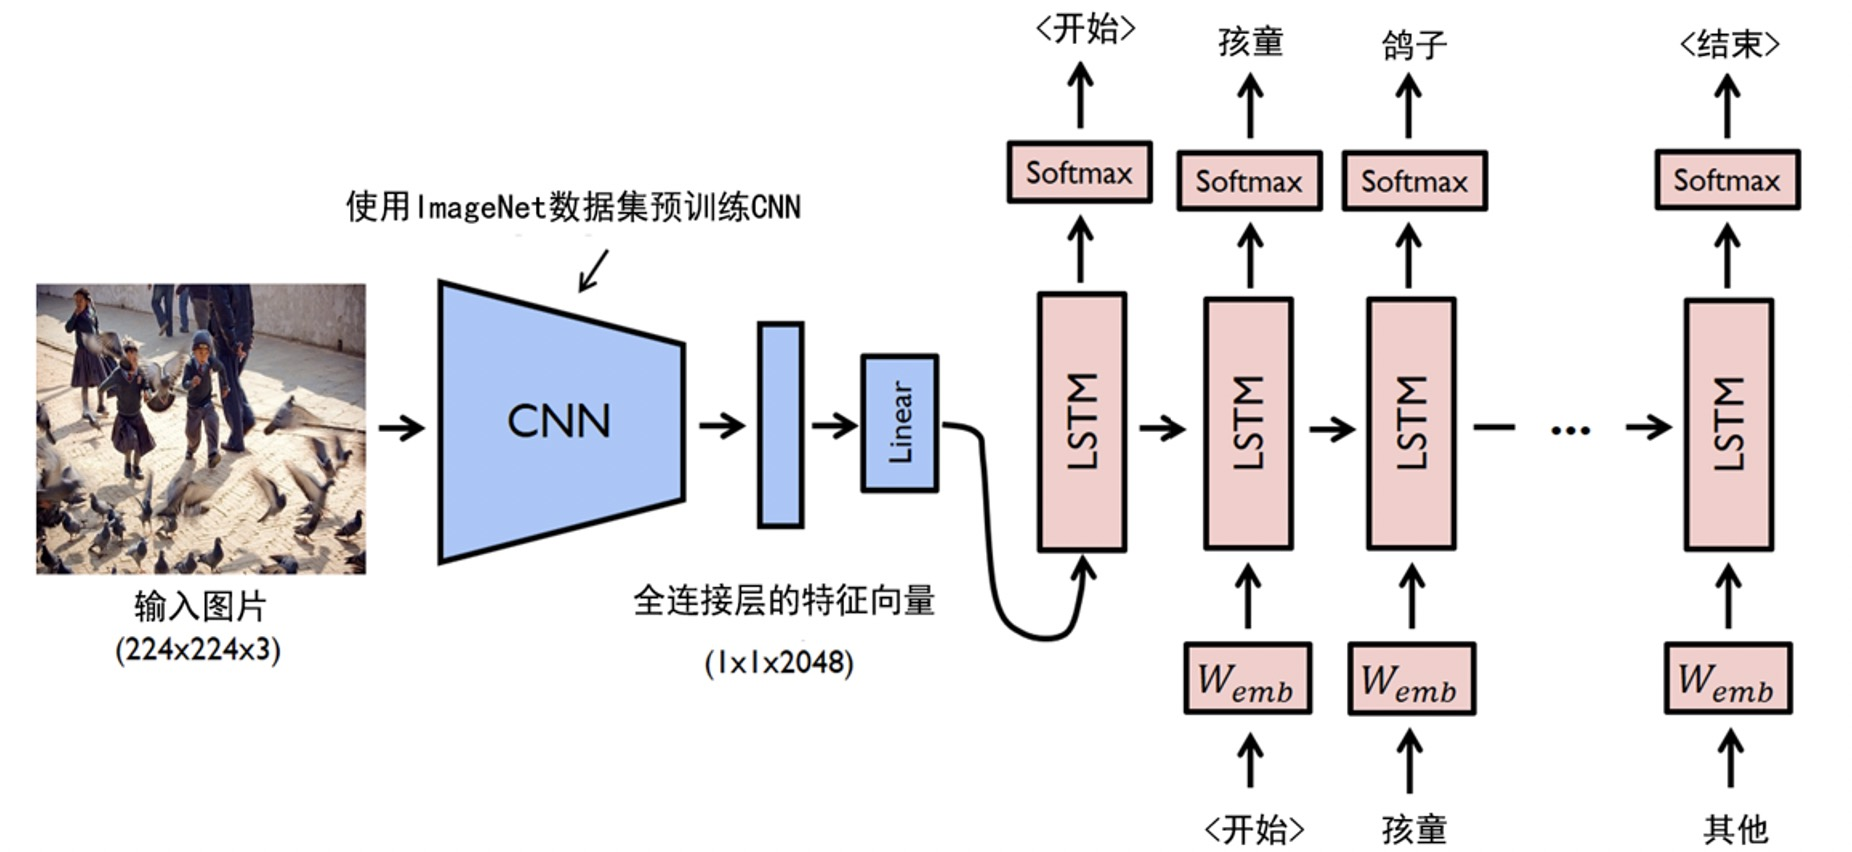

<font size=4>将图片提取出的2048 * 1 * 1的向量作为Encoder的输入，输入到Encoder LSTM中，</font>

<font size=4>Encoder输出的隐藏状态作为Decoder的初始隐藏状态，</font>

<font size=4>描述1作为Decoder输入，描述2作为标签（与模型输出对比计算交叉熵损失更新参数完成训练）</font>

In [85]:
#将超参数单独列出方便调整
unit_size = 2048#词嵌入隐藏层的维度
#这里调整的比较大是考虑到
#实际上整个词汇库里每一个词语就代表一种独立的事物，
#使用更大的词嵌入维度可以更细致的区分每个词语之间的差别
lr = 0.01   #学习率
decay = 0.  #学习率衰减率
reg = 1e-4  #正则化项的参数

In [86]:
def NICmodel(vocab_size, max_len, reg):
    #图像特征处理
    #输入的是预训练inception提取好的2048*1*1的向量
    inputs1 = Input(shape=(2048,))
    X_img = Dropout(0.5)(inputs1)
    #注意这里的dense层没有bias而且没有激活函数
    #本质上是在做一种线性变换，
    X_img = Dense(unit_size, use_bias = False, 
                        kernel_regularizer=regularizers.l2(reg),
                        name = 'dense_img')(X_img)
    X_img = BatchNormalization(name='batch_normalization_img')(X_img)
    #这一层也是扩展维度，以适应后面encoderLSTM的输入维度要求
    X_img = Lambda(lambda x : K.expand_dims(x, axis=1))(X_img)

    # 文本向量处理层
    #输入是长为max_len的向量
    inputs2 = Input(shape=(max_len,))
    #词嵌入wordembedding
    X_text = Embedding(vocab_size, unit_size, mask_zero = True, name = 'emb_text')(inputs2)
    X_text = Dropout(0.5)(X_text)#防止过拟合

    # 初始化LSTM的隐藏状态
    a0 = Input(shape=(unit_size,))
    c0 = Input(shape=(unit_size,))
    
    #将LSTM提前设置好参数方便后续调用
    #注意这里设置的是返回LSTM处理后的序列，以及两个隐藏状态
    LSTMLayer = LSTM(unit_size, return_sequences = True, return_state = True, dropout=0.5, name = 'lstm')

    # 将图片转为向量作为input，输入到encoderLSTM中
    #这里主要的部分是encoder输出的两个隐藏状态
    _, a, c = LSTMLayer(X_img, initial_state=[a0, c0])

    #注意这里刚刚encoder输出的隐藏状态被作为了decoder的初始隐藏状态
    #这里a,c两个隐藏状态就充当了encoder和decoder之间传递语义信息的桥梁
    A, _, _ = LSTMLayer(X_text, initial_state=[a, c])
    output = TimeDistributed(Dense(vocab_size, activation='softmax',
                                     kernel_regularizer = regularizers.l2(reg), 
                                     bias_regularizer = regularizers.l2(reg)), name = 'time_distributed_softmax')(A)

    return Model(inputs=[inputs1, inputs2, a0, c0], outputs=output, name='NIC')

#这里再定义一个预测模型，与训练模型稍有区别
#但是后面可以看到预测模型在使用时直接被赋予了训练模型相同的参数权重weights
def greedy_inference_model(vocab_size, max_len):
    
    #把要用到的层设置好参数方便调用
    #后面会看到这些层的权重都会被赋予与训练模型相同的值
    EncoderDense = Dense(unit_size, use_bias=False, name = 'dense_img')
    EmbeddingLayer = Embedding(vocab_size, unit_size, mask_zero = True, name = 'emb_text')
    LSTMLayer = LSTM(unit_size, return_state = True, name = 'lstm')
    SoftmaxLayer = Dense(vocab_size, activation='softmax', name = 'time_distributed_softmax')
    BatchNormLayer = BatchNormalization(name='batch_normalization_img')

    # 图片特征处理（与训练模型无区别）
    inputs1 = Input(shape=(2048,))
    X_img = EncoderDense(inputs1)
    X_img = BatchNormLayer(X_img)
    X_img = Lambda(lambda x : K.expand_dims(x, axis=1))(X_img)

    # 描述文本向量处理()
    inputs2 = Input(shape=(1,))
    X_text = EmbeddingLayer(inputs2)

    # 初始化
    a0 = Input(shape=(unit_size,))
    c0 = Input(shape=(unit_size,))

    a, _, c = LSTMLayer(X_img, initial_state=[a0, c0])

    x = X_text

    outputs = []#用于记录每一次预测的结果
    #注意这里实质上就是文本模型预测时挨个预测下一个字的操作
    #在作诗模型中是在模型之外进行的（预测出来的作为下次的输入）
    for i in range(max_len):
        #注意这里在连续的LSTM间传递的每一次的输出a和长期隐藏状态c
        a, _, c = LSTMLayer(x, initial_state=[a, c])
        output = SoftmaxLayer(a)
        outputs.append(output)
        #每预测一个字时的整个输出经过变换维度的处理后
        #直接作为下一个LSTM的输入，从而循环预测每一个字
        x = Lambda(lambda x : K.expand_dims(K.argmax(x)))(output)
        x = EmbeddingLayer(x)

    return Model(inputs=[inputs1, inputs2, a0, c0], outputs=outputs, name='NIC_greedy_inference_v2')

In [87]:
#存储模型的路径
model_dir = 'Models/Image Caption/image_caption_model_weights.h5'
#构造训练用模型
model = NICmodel(vocab_size, max_length, reg)

#如果没有已经训练好的模型则训练一个新模型
if not os.path.exists(model_dir):
    # 编译模型并对模型进行训练
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = lr, decay=decay), metrics=['accuracy'])

    tfcallbacks = [
        #使用早停和学习率衰减技术
        EarlyStopping(monitor='loss',patience = 10,min_delta=0),
        ReduceLROnPlateau(monitor='loss', patience=6, mode='auto')
    ]

    steps = len(descriptions)
    batch_size = 64

    # 训练集和测试集的数据生成器
    generator = data_generator(batch_size, descriptions_train, features_train, tokenizer, max_length, vocab_size)
    validation_generator = data_generator(batch_size, descriptions_val, features_val, tokenizer, max_length, vocab_size)

    # 对模型进行训练
    history = model.fit_generator(generator, epochs=500, validation_data=validation_generator,
                                  validation_steps=int(np.ceil(len(descriptions_val) / batch_size)), callbacks=tfcallbacks,
                                  steps_per_epoch=int(np.ceil(len(descriptions_train) / batch_size)), verbose=2)
    #将模型存储起来
    model_files='Models/Image Caption'
    os.mkdir(model_files)
    model.save_weights(model_dir)

<font size=4>**将用训练好的模型预测新样本写成一系列函数方便调用**</font>

In [88]:
model_dir = 'Models/Image Caption/image_caption_model_weights.h5'
vocab_size = len(tokenizer.word_index) + 1
#注意这里新构造了一个上面定义好的预测用的模型
NIC_inference = greedy_inference_model(vocab_size, max_length)
#以层的名字为依据对预测模型每层逐一赋予与训练模型相同的权重
NIC_inference.load_weights(model_dir, by_name = True, skip_mismatch=True)

In [89]:
# 对待预测图片提取图片特征，适合开头一样的迁移学习方法
def extract_features(filename):
    #通过model.predict提取图片特征
    in_layer = Input(shape=(224, 224, 3))

    base_model = InceptionV3(weights='imagenet', input_tensor=in_layer) 
    #base_model = VGG16(include_top=False,weights='imagenet')
    base_model.trainable=False
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    return model.predict(image)

#用样本图片特征预测描述文本
def decoder(inf_model, tokenizer, features, post_process = True):
    #检验输入的图片格式是否符合要求
    assert(features.shape[0]>0 and features.shape[1] == 2048)

    N = features.shape[0]
    #初始化文本序列输入和有隐藏状态输入
    startseq = np.repeat([tokenizer.word_index['startseq']], N)
    a0 = np.zeros([N, unit_size])
    c0 = np.zeros([N, unit_size])

    # 使用预测模型预测出每个位置词语是各个词的概率矩阵
    y_preds = np.array(inf_model.predict([features, startseq, a0, c0], verbose = 0))

    # 这里调整了一下维度顺序（广义的转置）
    y_preds = np.transpose(y_preds, axes = [1,0,2])
    # print(y_preds)
    
    #使用argmax函数找到每一个位置概率最大的词直接作为预测结果
    sequences = np.argmax(y_preds,axis = -1)
    #将数字向量映射回文本
    sents = tokenizer.sequences_to_texts(sequences)

    #用一个循环和判断只保留到endseq为止的预测结果
    if post_process:
        sents_pp = []
        for sent in sents:
            if 'endseq' in sent.split():
                words = sent.split()
                sents_pp.append(' '.join(words[:words.index('endseq')]))
            else:
                sents_pp.append(sent)
        sents = sents_pp

    return sents

def generate_caption_from_directory(file_directory):
    tokenizer = load(open('MiddleFiles/tokenizer.pkl', 'rb'))
    # 提取待预测样本特征
    img_features_dict = extract_features(file_directory)
    # 根据图片特征生成描述语句
    captions = decoder(NIC_inference, tokenizer, img_features_dict, True)
    
    return captions

# 二、关键词嵌入

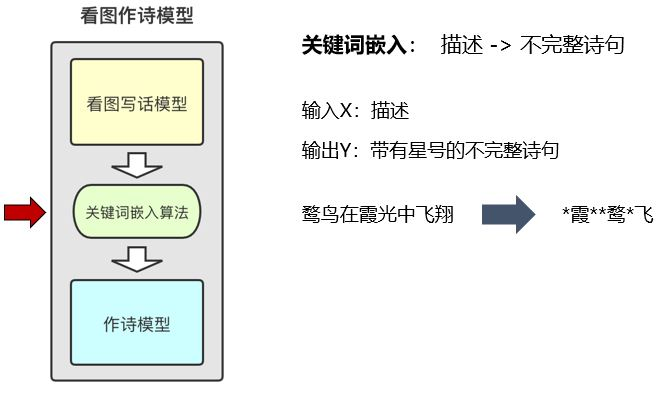

## 构建诗句词汇库

<font size=3>用于后续与描述语句关键词进行对比</font>

In [90]:
#读入诗
df = pd.read_csv("Data/Poems/宋_2.csv", encoding="utf-8")
df.head()

,题目,朝代,作者,内容
0,次韵王适州学新修水阁,宋,苏辙,黄钟巨挺两舂容，何幸幽居近学宫。坐对江山增浩气，力追齐鲁欲同风。颂诗闻道求何武，家法行看试左...
1,次韵王适春雨,宋,苏辙,久遭客禁往还稀，风雨萧条只自知。春色有情犹入眼，客愁无赖巧侵眉。山僧寄语收茶日，野老留人供社...
2,次韵王适春雪二首 其一,宋,苏辙,江南春候寒犹剧，细雨风吹作雪花。中夜窗扉初晃漾，平明草木半低斜。润催江柳排金绿，光杂山茶点绛...
3,次韵王适食茅栗,宋,苏辙,相从万里试南餐，对案长思苜蓿盘。山栗满篮兼白黑，村醪入口半甜酸。久闻牛尾何曾试，窃比鸡头意未...
4,次韵王适留别,宋,苏辙,远谪劳君两度行，复将文字试平衡。干时岂为斗升禄，闻道应忘宠辱惊。未了新书谁与读，重留佳句不胜...


In [91]:
poemall = []  # 用于存放正常诗句中的词语
for line in df['内容']:
    line = line.replace('，', ' ') 
    line = line.replace('。', ' ') 
    line = line.split(" ")
    textnew = []
    for t in line:
        if(len(t)>=5):
            textnew.append(t)
    poemall.extend(textnew)

#统计诗歌数据中的所有词语
word_dict = {} # 字典（key-value）
for i in range(len(poemall)):
    prodname = list(jieba.cut(poemall[i],cut_all=True))
    for word in prodname :
        if word not in word_dict: # 统计词频
            word_dict[word] = 1
        else:
            word_dict[word] += 1
word_list = list(word_dict.keys())

word_list[:5]

['黄', '钟', '巨', '挺', '两']

In [92]:
#生成所有诗歌使用的单个字列表
f = df["内容"]
poems_word = []#用于存放正常诗句
for line in f:
    text = line
    text = text.replace('，', ' ') 
    text = text.replace('。', ' ') 
    text = text.split(" ")
    i = 0
    while (len(text[i])>=5) and (len(text[i])<=7) :
        #每两句一起处理
        for t in text[i]:
            if t not in poems_word :
                poems_word.append(t)
        for t in text[i+1]:
            if t not in poems_word :
                poems_word.append(t)
        i += 2
        if((i+1)>=len(text)):
            break
        
poems_word[:5]

['黄', '钟', '巨', '挺', '两']

In [93]:
#将字库与词库取并集
for t in poems_word:
    if t not in word_list:
        word_list.append(t)
        
word_list[:5]

['黄', '钟', '巨', '挺', '两']

## 关键词嵌入具体实现

<font size=3>具体步骤：</font>

<font size=3>1. 构建诗句数据集字词库</font>

<font size=3>2. 对描述文本进行全分词(提取所有可能的字词)</font>

<font size=3>3. 筛选在诗句字词库中的关键词，只保留动、名词</font>

<font size=3>4. random shuffle将关键词随机打乱</font>

<font size=3>5. 根据词性插入不完整诗句，其余用星号补全</font>

In [94]:
#关键词嵌入
def insert_keywords(caption, random_seed):
    #输入的图片描述caption
    a = caption
    #进行结巴分词
    alist = list(jieba.cut(a,cut_all=True))
    #同时把句子中的每个单独的字也加进来
    alist.extend(list(a))
    #以空格分隔合并起来达到一种全分词的效果
    a = " ".join(alist)

    #生成带有词性标注的字典
    alist = dict(jieba.posseg.cut(a))
    # print(alist)

    allist = []
    nlist = []#用于存放词语本身
    poslist = []#用于存放对应的词性
    #对每个关键词进行词性筛选
    #只保留n开头的词性（名词、动名词等）以及动词v
    for word, poseg in alist.items() :
            if poseg[0] == 'n' or poseg == "v":
                nlist.append(word)
                poslist.append(poseg)

    #这部分是为了提出不在诗词词库里的字词
    inlist = []#包含在诗词词库中的字词
    inpos = []#词性列表
    outlist = []#不包含在诗词词库里的字词
    outpos = []#词性列表
    #与作诗部分最开头生成的诗词词库进行筛选只保留“认识”的字词
    for i in range(len(nlist)):
        if nlist[i] in word_list: 
            inlist.append(nlist[i]) 
            inpos.append(poslist[i])
        if nlist[i] not in word_list: 
            outlist.append(nlist[i]) 
            outpos.append(poslist[i])
    
    flist = inlist
    plist = inpos

    fpdic=dict(zip(flist,plist))#生成词语词性词典方便打乱后对应
    random.seed(random_seed)
    r = random.random
    #对关键词随机打乱
    random.shuffle(flist, random=r)
    #将词性与词语在此对应起来
    plist = [fpdic[x] for x in flist]
    
    #用于生成不完整诗句
    sentence = []
    i = 0
    countn = 0
    for i in range(len(flist)):
        #整体的思路是名词一般优先放句首
        #动词跟在名词后隔几个的位置
        #生成满四句不完整诗句为止
        if countn >= 4:
            break
        if plist[i]=='v':
            #动词一般和前一个名词是主谓关系
            #所以同时处理
            i += 1
            continue
        if plist[i][0]=='n':
            sent = list(flist[i])
            #根据已经插入的关键词长度补充*号
            sent.extend(['*']*(7-len(flist[i])))
            # print(sent)
            countn += 1
        if i<(len(flist)-1) and plist[i+1]=='v':
            sent[len(flist[i])+1] = flist[i+1]
        sent = "".join(sent)
        sentence.append(sent)
    #当关键词不够多，甚至不够4个时,补充够未完整诗句的数量
    while len(sentence)<4 :
        sent = ['*']*(7)
        sent = "".join(sent)
        sentence.append(sent)
    #将上下句合并(为了适应做事部分不完整诗句的格式)
    combined = []
    sent1 = "".join([sentence[0],sentence[2]])
    sent2 = "".join([sentence[1],sentence[3]])
    combined.append(sent1)
    combined.append(sent2)
    
    return combined

# 三、作诗模型

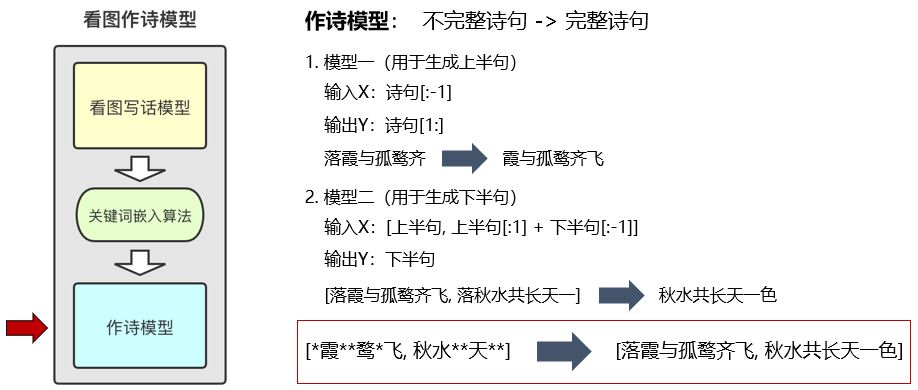

## 构建训练集和测试集

In [95]:
f = df["内容"]
poems = []#用于存放正常诗句
duals1 = []#用于存放上下句对换位置的诗句
duals2 = []#用于存放上下句对换位置的诗句
for line in f:
    text = line
    text = text.replace('，', ' ') 
    text = text.replace('。', ' ') 
    text = text.split(" ")
    i = 0
    while (len(text[i])>=5) and (len(text[i])<=7) :
        #每两句一起处理
        b = text[i][0]
        poems.append(list(text[i]))
        poems.append(list(text[i+1]))
        #对偶句加进list时顺序反过来
        duals1.append(list(text[i]))
        duals2.append(list(b)+list(text[i+1]))
        i += 2
        if((i+1)>=len(text)):
            break
        
print(poems[0]) 
print(duals1[0])
print(duals2[0])

['黄', '钟', '巨', '挺', '两', '舂', '容']
['黄', '钟', '巨', '挺', '两', '舂', '容']
['黄', '何', '幸', '幽', '居', '近', '学', '宫']


## 构建将文本序列转换为数字序列的tokenizer

In [96]:
poemtokenizer = Tokenizer()  # 对字进行数字编码的tokenizer
poemtokenizer.fit_on_texts(poems)
#将训练数据文本映射为数字
poems_digit = poemtokenizer.texts_to_sequences(poems)
duals1_digit = poemtokenizer.texts_to_sequences(duals1)
duals2_digit = poemtokenizer.texts_to_sequences(duals2)

# 因为tokenizer的索引问题，需要加+1避免报错
vocab_size = len(poemtokenizer.word_index) + 1
print(poems_digit[0])
print(poems[0])
print(duals1_digit[0])
print(duals1[0])
print(duals2_digit[0])
print(duals2[0])

vocab_size

[112, 510, 1551, 2614, 178, 1775, 290]
['黄', '钟', '巨', '挺', '两', '舂', '容']
[112, 510, 1551, 2614, 178, 1775, 290]
['黄', '钟', '巨', '挺', '两', '舂', '容']
[112, 11, 581, 204, 236, 273, 238, 400]
['黄', '何', '幸', '幽', '居', '近', '学', '宫']


8085

In [97]:
# 对上面得到的长度不一的向量进行补零操作，使其等长
poems_digit = pad_sequences(poems_digit, maxlen=7, padding='post')
duals1_digit = pad_sequences(duals1_digit, maxlen=7, padding='post')
duals2_digit = pad_sequences(duals2_digit, maxlen=8, padding='post')
print("原始诗歌")
print(poems[3864])
print("\n")
print("编码+补全后的结果")
print(poems_digit[3864])

原始诗歌
['逃', '亡', '已', '觉', '依', '刘', '表']


编码+补全后的结果
[1588 1074   43  310  389 1170 1116]


In [98]:
#对训练时的输入和输出分别要做去尾和掐头的操作
X = poems_digit[:, :-1]
Y = poems_digit[:, 1:]
Xa = duals1_digit
Xb = duals2_digit[:, :-1]
Yb = duals2_digit[:, 1:]

print(poems_digit.shape)
print(X.shape)
print(Y.shape)
print(Xa.shape)
print(Xb.shape)
print(Yb.shape)

print("X示例", "\t", "Y示例")

for i in range(6):
    print(Xa[0][i], "\t", Y[0][i])

print("...", "\t", "...")

(624694, 7)
(624694, 6)
(624694, 6)
(312347, 7)
(312347, 7)
(312347, 7)
X示例 	 Y示例
112 	 510
510 	 1551
1551 	 2614
2614 	 178
178 	 1775
1775 	 290
... 	 ...


In [99]:
print(vocab_size)
#对作为标签的Y还要做onehot处理
#毕竟这本质是一个超高维分类问题
Y = to_categorical(Y, num_classes=vocab_size)
print(Y.shape)
Yb = to_categorical(Yb, num_classes=vocab_size)
print(Yb.shape)

8085
(624694, 6, 8085)
(312347, 7, 8085)


## 构建定义模型

### 奇数句

生成奇数句时，使用最基础的基于LSTM的作诗模型。

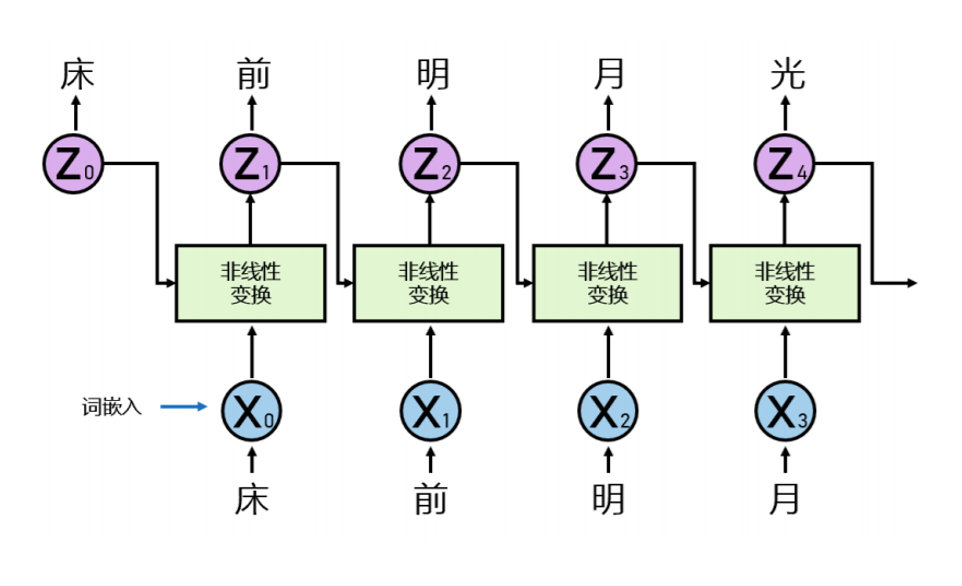

In [100]:
#定义预测奇数句的简单LSTM模型
hidden_size1 = 128
hidden_size2 = 64

inp1 = Input(shape=(6,))

# Encoder
# 模型尽行了调整，输入为两个部分，同样都用LSTM处理
x = Embedding(vocab_size, hidden_size1, input_length=6, mask_zero=True)(inp1)
x = LSTM(hidden_size2, return_sequences=True)(x)

# prediction
x = Dense(vocab_size)(x)
pred = Activation('softmax')(x)

model1 = Model(inputs=inp1, outputs=pred)
model1.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 6, 128)            1034880   
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 64)             49408     
_________________________________________________________________
dense_5 (Dense)              (None, 6, 8085)           525525    
_________________________________________________________________
activation_378 (Activation)  (None, 6, 8085)           0         
Total params: 1,609,813
Trainable params: 1,609,813
Non-trainable params: 0
_________________________________________________________________


In [101]:
#如果不存在现成的模型则须训练
if not os.path.exists('Models/Create Poems/model1.h5'):
    model_files='Models/Create Poems'
    os.mkdir(model_files)
    model1.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    model1.fit(X, Y, epochs=15, batch_size=1000, validation_split=0.2)
    model1.save("Models/Create Poems/model1.h5")
else:
    #存在已有模型则直接加载进来
    model1 = load_model("Models/Create Poems/model1.h5")

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### 偶数句

生成偶数句时，考虑上下句的对偶关系，将上句内容作为模型输入的一部分。

因此，我们的模型结构参考了机器翻译模型，加入了Encoder-Decoder框架，以完成序列到序列的映射任务

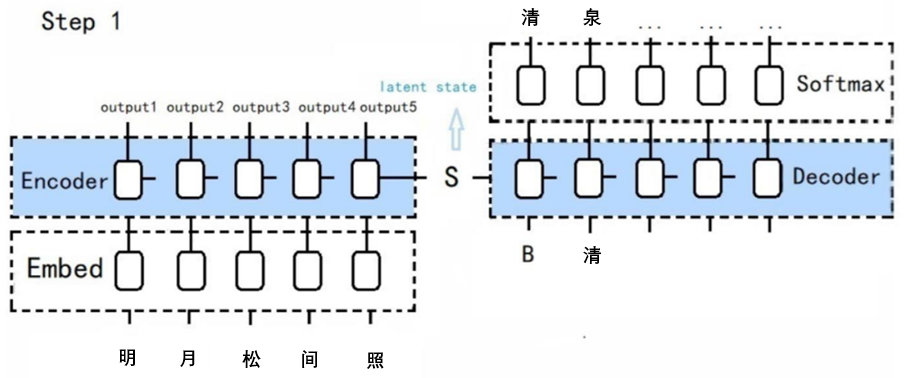

In [102]:
#定义预测偶数句的encoder-decoder模型
vocab_size = 8085
hidden_size_1 = 128
hidden_size_2 = 64

# Encoder（上半句作为输入）
#模型进行了调整，输入为两个部分，同样都用LSTM处理
encoder_input = Input(shape = (7,))
x = Embedding(vocab_size, hidden_size_1, mask_zero=True, name='shang')(encoder_input)
encoder_output,encoder_h,encoder_c = LSTM(hidden_size_2, return_state=True, name='Encoder')(x)

#encoder输出的隐藏状态作为decoder的初始隐藏状态
encoder_state = [encoder_h,encoder_c]

# decoder（下半句作为输入，同时在训练时也作为标签）
decoder_input = Input(shape=(7, ))
x = Embedding(vocab_size, hidden_size_1, mask_zero=True, name='xia')(decoder_input)
decoder_output = LSTM(hidden_size_2, return_sequences=True, name='Decoder')(x, initial_state=encoder_state)

pred = Dense(vocab_size, activation='softmax')(decoder_output)
model2 = Model([encoder_input,decoder_input],pred)
model2.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 7)            0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 7)            0                                            
__________________________________________________________________________________________________
shang (Embedding)               (None, 7, 128)       1034880     input_25[0][0]                   
__________________________________________________________________________________________________
xia (Embedding)                 (None, 7, 128)       1034880     input_26[0][0]                   
____________________________________________________________________________________________

In [103]:
#如果不存在现成的模型则须进行训练
if not os.path.exists('Models/Create Poems/model2.h5'):
    model2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
    model2.fit([Xa,Xb],Yb, epochs=15, batch_size=1000, validation_split=0.2)
    model2.save("Models/Create Poems/model2.h5")
else:
    #存在训练好的模型时直接load进来
    model2 = load_model("Models/Create Poems/model2.h5")

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## 实现作诗

<font size=4>将使用两个模型预测出整首诗的过程定义为方便调用的函数</font>

In [104]:
def create_poems(poem_incompletes, keywords):
    # 添加了一个奇偶数句标记
    tlist = keywords
    Tlist = []
    for t in tlist:
        Tlist.append(poemtokenizer.word_index[t])
    poem_incomplete = poem_incompletes[0]  # 不完整诗句
    poem_index = []#存储已有的完整诗句的index
    poem_text = ''
    #生成第一句
    for i in range(7):
        current_word = poem_incomplete[i]

        if  current_word != '*':
            #碰到插入的确定词语
            index = poemtokenizer.word_index[current_word]

        else:
            #如果该位置不确定（即为*）
            #利用已有的句子预测这个位置的字
            x = np.expand_dims(poem_index, axis=0)
            x = pad_sequences(x, maxlen=6, padding='post')
            y = model1.predict(x)[0, i-1]

            y[0] = 0            #去掉停止词
            index = y.argmax()
            current_word = poemtokenizer.index_word[index]

        poem_index.append(index)
        poem_text = poem_text + current_word


    dual_index = [Tlist[0]]
    #接着继续生成第二句
    for i in range(7,14):
        current_word = poem_incomplete[i]

        if  current_word != '*':
            #碰到插入的确定词语
            index = poemtokenizer.word_index[current_word]

        else:
            #如果该位置不确定（即为*）
            #利用完整的上半句的句子和已经预测出的下半句的字预测这个位置的字
            x1 = np.expand_dims(poem_index[(i-7):], axis=0)
            x1 = pad_sequences(x1, maxlen=7, padding='post')
            x2 = np.expand_dims(dual_index, axis=0)
            x2 = pad_sequences(x2, maxlen=7, padding='post')
            y = model2.predict([x1,x2])[0, (i-7)]

            y[0] = 0            #去掉停止词
            index = y.argmax()
            current_word = poemtokenizer.index_word[index]


        poem_index.append(index)
        dual_index.append(index)
        poem_text = poem_text + current_word

    #添加了一个奇偶数句标记
    #生成第34句
    poem_incomplete = poem_incompletes[1]  # 这里还是先人工把关键词加入诗句吧
    poem_index2 = []#存储已有的完整诗句的index
    poem_text2 = ''
    #上半句
    for i in range(7):
        current_word = poem_incomplete[i]

        if  current_word != '*':
            #碰到插入的确定词语
            index = poemtokenizer.word_index[current_word]

        else:
            #如果该位置不确定（即为*）
            #利用已经预测出的字预测这个位置的字
            x = np.expand_dims(poem_index2, axis=0)
            x = pad_sequences(x, maxlen=6, padding='post')
            y = model1.predict(x)[0, i-1]

            y[0] = 0            #去掉停止词
            index = y.argmax()
            current_word = poemtokenizer.index_word[index]

        poem_index2.append(index)
        poem_text2 = poem_text2 + current_word


    dual_index2 = [Tlist[1]]
    #第四句（下半句）
    for i in range(7,14):
        current_word = poem_incomplete[i]

        if  current_word != '*':
            #碰到插入的确定词语
            index = poemtokenizer.word_index[current_word]

        else:
            #如果该位置不确定（即为*）
            #利用完整的上半句的句子x1和已经预测出的下半句的部分字x2预测这个位置的字
            x1 = np.expand_dims(poem_index2[(i-7):], axis=0)
            x1 = pad_sequences(x1, maxlen=7, padding='post')
            x2 = np.expand_dims(dual_index2, axis=0)
            x2 = pad_sequences(x2, maxlen=7, padding='post')
            y = model2.predict([x1,x2])[0, (i-7)]

            y[0] = 0            #去掉停止词
            index = y.argmax()
            current_word = poemtokenizer.index_word[index]


        poem_index2.append(index)
        dual_index2.append(index)
        poem_text2 = poem_text2 + current_word

    poem_text = poem_text[0:]#第12句
    poem_text2 = poem_text2[0:]#第34句
    #输出生成好的诗句
    print(poem_text[0:7])
    print(poem_text[7:14])
    print(poem_text2[0:7])
    print(poem_text2[7:14])

# 应用示例

### 示例一

请输入图片名:划船6
预测描述: 在水中划船的人


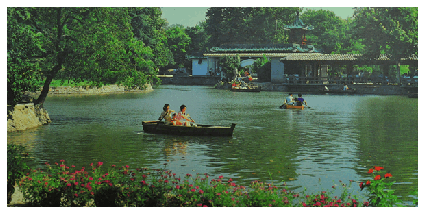

In [105]:
#对新图片提取特征并预测描述语句

image_name = input('请输入图片名:')
image_file_dir = f'Data/Images/SampleImages/{image_name}.jpg'

# 展示图片
img = mpimg.imread(image_file_dir)
plt.axis('off')
plt.tight_layout()
plt.imshow(img)
plt.tight_layout()

# 载入图片进行预测
description = generate_caption_from_directory(image_file_dir)[0].replace(' ', '')
print('预测描述:', description)

In [106]:
#根据描述语句生成不完整诗句
sentence = insert_keywords(description, random_seed=1331)
print(sentence)

['船*划****水******', '人*************']


In [107]:
#使用作诗模型作诗
create_poems(sentence, [sentence[0][0], sentence[1][0]])

船头划见水云间
水云深处是人间
人间不见人间事
一笑相从不敢忘


### 示例二

请输入图片名: 院长致辞


预测描述: 有一个人面前有话筒


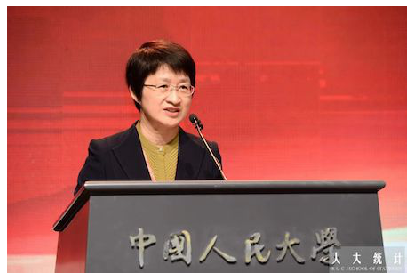

In [31]:
image_name = input('请输入图片名:')
image_file_dir = f'Data/Images/SampleImages/{image_name}.jpg'

# 展示图片
img = mpimg.imread(image_file_dir)
plt.axis('off')
plt.tight_layout()
plt.imshow(img)
plt.tight_layout()

# 载入图片进行预测
description = generate_caption_from_directory(image_file_dir)[0].replace(' ', '')
print('预测描述:', description)

In [32]:
insert_keywords('有一个人面前有话筒', random_seed=1)

['人******', '话筒*****', '面******', '话******']

In [34]:
create_poems(['人******话筒*****', '面******话******'], ['话', '面'])

人生不可问人间
话筒犹有一生心
面面不知人物物
话闲不用一杯中


### 示例三

请输入图片名:自行车
预测描述: 有很多人正在骑自行车


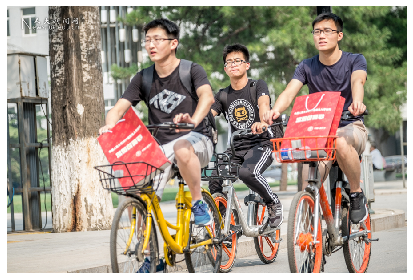

In [139]:
image_name = input('请输入图片名:')
image_file_dir = f'Data/Images/SampleImages/{image_name}.jpg'

# 展示图片
img = mpimg.imread(image_file_dir)
plt.axis('off')
plt.tight_layout()
plt.imshow(img)
plt.tight_layout()

# 载入图片进行预测
description = generate_caption_from_directory(image_file_dir)[0].replace(' ', '')
print('预测描述:', description)

In [144]:
sentence = insert_keywords(description, random_seed=445)
print(sentence)

['行车*****自行车****', '人*有***********']


In [145]:
create_poems(sentence, [sentence[0][0], sentence[0][7]])

行车不见人间事
自行车马不须臾
人间有客无人语
不知何处是人情


# 一些拓展

<font size=4>1. 由于计算资源限制，使用的是较为基础的flickr8k-CN数据集，这使得目前模型能够识别出来的事物局限于数据集中的常见的事物（如山、水、船、人、动物等），建议计算资源允许的话可以尝试其他数据量更大内容更丰富的数据集，如COCO-CN等，能够识别出来的事物更丰富，整体作诗的效果也会更好。（当然这也能够解决下面所说的部分图片生成的描述较为简单的问题）</font>

<font size=4>2. 看图写话模型可考虑引入attention机制，进一步提高预测精度。</font>

<font size=4>3. 对一些图片生成的描述可能比较简单，则提取出的关键词个数较少，这可能会使得作诗效果较差。可以在关键词嵌入部分尝试使用synonym包（同义词），进行词语（同义词）联想，弥补关键词较少的缺陷。</font>

<font size=4>4. 可以尝试将作诗的模型替换为其他模型，生成其他风格的文字（比如周杰伦歌词风…）</font>

<font size=4>5. 使用的诗歌数据集也可以尝试替换为其他韵律对偶更加明显的数据集，在生成诗句时也可以进一步考虑基于Beam Search的韵脚奖惩搜索机制，使诗句更具韵律。</font>